In this project, we will analyze the dataset from Kaggle (https://www.kaggle.com/crowdflower/twitter-airline-sentiment) which contains **14,640** tweets posted in February 2015. These tweets are the passenger comments after their flight with different airline companies. The Tweets are classified into positive, neutral and negative. In this code, we will build wordlcoud and perform Topic modeling for the negative tweets


In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
sns.set(style="dark")
import matplotlib.pyplot as plt
%matplotlib inline
import re
from wordcloud import WordCloud, STOPWORDS 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [0]:
# read csv file
airline = pd.read_csv('Tweets.csv')

In [5]:
airline.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


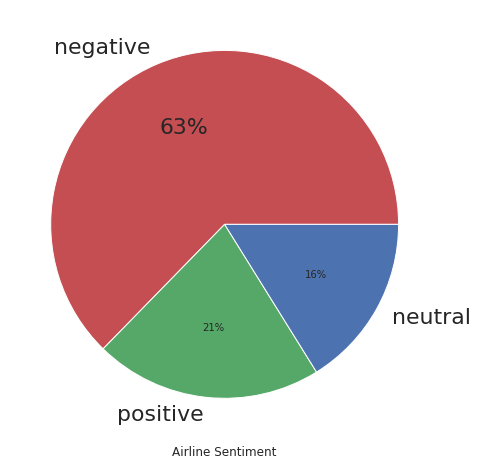

In [6]:
fig = plt.figure(figsize=(15,8))
ax = fig.subplots(1,1)
labels = ['negative','positive','neutral']
patches, texts, autotexts = ax.pie(airline.airline_sentiment.value_counts(), labels=labels,autopct='%1.0f%%',colors=['r','g','b'])
texts[0].set_fontsize(22)
texts[1].set_fontsize(22)
texts[2].set_fontsize(22)
plt.xlabel('Airline Sentiment')
autotexts[0].set_fontsize(22)


Let us take a look at the number of tweets per airline


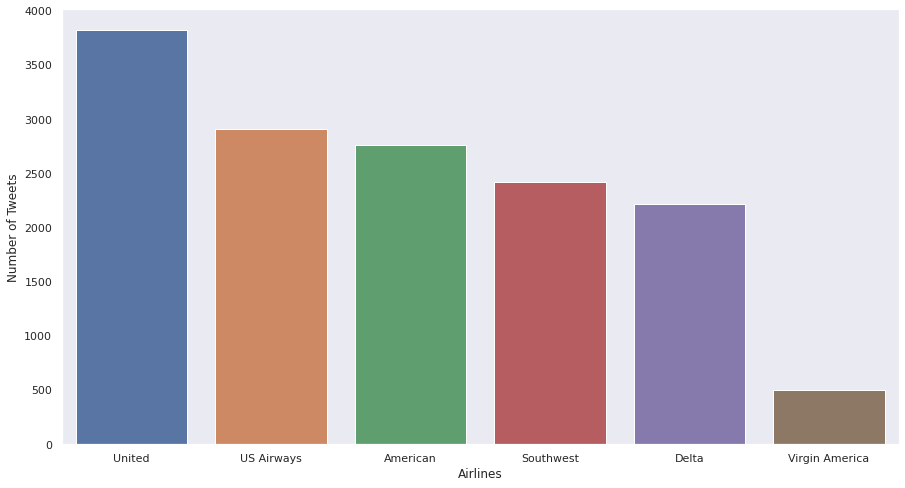

In [7]:
fig = plt.figure(figsize=(15,8))
ax = fig.subplots(1,1)
sns.countplot(x = 'airline', data = airline, order = airline['airline'].value_counts().index,);
#patches, texts, autotexts = ax.bar(airline.airline_sentiment.value_counts(),height = 0.8)
sns.set_context('poster', font_scale = 0.5) 
fig.show()
plt.xlabel('Airlines')
plt.ylabel('Number of Tweets');

In [8]:
sentiment_by_airline_df = pd.crosstab(airline['airline'],airline['airline_sentiment']).reset_index()
sentiment_by_airline_df

airline_sentiment,airline,negative,neutral,positive
0,American,1960,463,336
1,Delta,955,723,544
2,Southwest,1186,664,570
3,US Airways,2263,381,269
4,United,2633,697,492
5,Virgin America,181,171,152


In [9]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[
        go.Bar(
            name="Positive",
            x=sentiment_by_airline_df["airline"],
            y=sentiment_by_airline_df["positive"],
            offsetgroup=0,
        ),
        go.Bar(
            name="Negative",
            x=sentiment_by_airline_df["airline"],
            y=sentiment_by_airline_df["negative"],
            offsetgroup=1,
        ),
        go.Bar(
            name="Neutral",
            x=sentiment_by_airline_df["airline"],
            y=sentiment_by_airline_df["neutral"],
            offsetgroup=2,
        )
    ],
    layout=go.Layout(
        title="Sentiments - Positive, Neutral and Negative",
        yaxis_title="Number of Tweets"
    )
)

fig.show()

It can be seen that the for most of the airlines the negative sentiments are higher than positive and neutral sentiments. Only for Virgin Airlines the proportion of positive, negative and neutral sentiments are similar



In [0]:
comment_words = ' '
stopwords = set(STOPWORDS)

In [0]:
# Clean tweets beforehand to improve word cloud, remove user handles, stop words, word less than 3 characters, etc
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [0]:
# remove twitter handles (@user)
airline['cleaned_tweet'] = np.vectorize(remove_pattern)(airline['text'], "@[\w]*")
# remove special characters, numbers, punctuations
airline['cleaned_tweet'] = airline['cleaned_tweet'].str.replace("[^a-zA-Z]", " ")
# remove words less than 3 characters long
airline['cleaned_tweet'] = airline['cleaned_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [13]:
airline.iloc[0:5][['airline','airline_sentiment','cleaned_tweet']]

,airline,airline_sentiment,cleaned_tweet
0,Virgin America,neutral,What said
1,Virgin America,positive,plus added commercials experience tacky
2,Virgin America,neutral,didn today Must mean need take another trip
3,Virgin America,negative,really aggressive blast obnoxious entertainmen...
4,Virgin America,negative,really thing about


In [0]:
pos_df = airline[airline['airline_sentiment']=='positive']

# Negative
neg_df = airline[airline['airline_sentiment']=='negative']

# Neutral
neu_df = airline[airline['airline_sentiment']=='neutral']

In [0]:
def createWordcloud(df):
    wordcloud = WordCloud(
                    background_color='white',
                    stopwords=stopwords,
                    max_words=75,
                    max_font_size=40,
                    random_state=42).generate(str(df['cleaned_tweet']))
    print(wordcloud)
    fig = plt.figure(1, figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

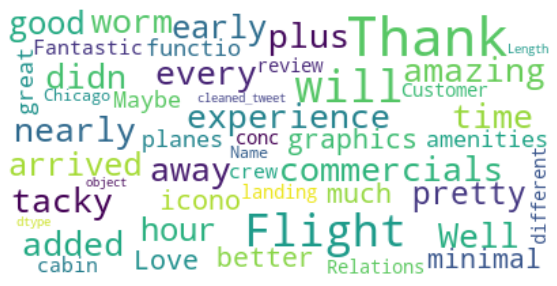

In [16]:
createWordcloud(pos_df);

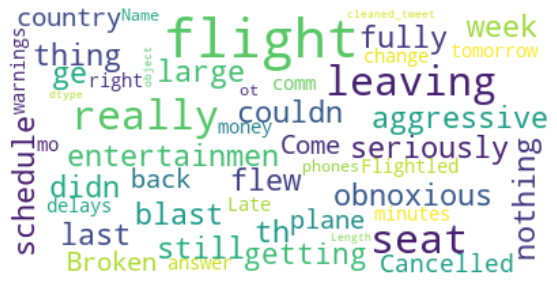

In [17]:
createWordcloud(neg_df);

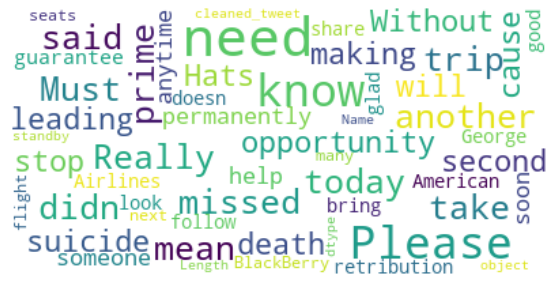

In [18]:
createWordcloud(neu_df);

In [20]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 41.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=a6e273c780a2c8aa8e1a837d0d36422d0dc82155edca93835f97f8b099d078ea
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=1425a1a72de24a75a2857a7d266ef60fd5e638b86b304046c123147ef13e7530
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [0]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
pos_tweet_words = list(sent_to_words(pos_df['cleaned_tweet']))
neg_tweet_words = list(sent_to_words(neg_df['cleaned_tweet']))

In [0]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [0]:
# Define function lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [0]:
pos_tweet_lemmatized = lemmatization(pos_tweet_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
neg_tweet_lemmatized = lemmatization(neg_tweet_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [0]:
# Create Dictionary
pos_id2word = corpora.Dictionary(pos_tweet_lemmatized)
neg_id2word = corpora.Dictionary(neg_tweet_lemmatized)

# Term Document Frequency
pos_corpus = [pos_id2word.doc2bow(text) for text in pos_tweet_lemmatized]
neg_corpus = [neg_id2word.doc2bow(text) for text in neg_tweet_lemmatized]


In [0]:
# Build LDA model
pos_lda_model = gensim.models.ldamodel.LdaModel(corpus=pos_corpus,
                                           id2word=pos_id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=5000,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
neg_lda_model = gensim.models.ldamodel.LdaModel(corpus=neg_corpus,
                                           id2word=neg_id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=5000,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [29]:
from pprint import pprint
pprint(pos_lda_model.print_topics())

[(0,
  '0.108*"thank" + 0.048*"much" + 0.027*"response" + 0.026*"follow" + '
  '0.026*"appreciate" + 0.017*"send" + 0.016*"very" + 0.015*"help" + '
  '0.014*"quick" + 0.013*"amazing"'),
 (1,
  '0.067*"thank" + 0.027*"help" + 0.023*"just" + 0.020*"flight" + 0.013*"guy" '
  '+ 0.012*"good" + 0.010*"more" + 0.009*"team" + 0.008*"http" + '
  '0.008*"plane"'),
 (2,
  '0.051*"flight" + 0.032*"time" + 0.026*"thank" + 0.026*"love" + 0.024*"make" '
  '+ 0.018*"fly" + 0.010*"great" + 0.010*"good" + 0.010*"always" + '
  '0.009*"last"'),
 (3,
  '0.067*"flight" + 0.049*"great" + 0.024*"thank" + 0.022*"crew" + '
  '0.017*"service" + 0.017*"today" + 0.016*"know" + 0.013*"just" + '
  '0.012*"help" + 0.012*"tonight"'),
 (4,
  '0.053*"thank" + 0.027*"flight" + 0.023*"look" + 0.013*"forward" + '
  '0.012*"first" + 0.012*"get" + 0.011*"fly" + 0.011*"change" + 0.011*"time" + '
  '0.011*"great"'),
 (5,
  '0.169*"thank" + 0.027*"customer" + 0.025*"service" + 0.022*"just" + '
  '0.022*"will" + 0.018*"guy" + 0

In [30]:
from pprint import pprint
pprint(neg_lda_model.print_topics())

[(0,
  '0.054*"plane" + 0.035*"flight" + 0.027*"wait" + 0.025*"hour" + 0.018*"bag" '
  '+ 0.018*"gate" + 0.017*"sit" + 0.016*"people" + 0.015*"delay" + '
  '0.014*"still"'),
 (1,
  '0.038*"hold" + 0.037*"hour" + 0.037*"flight" + 0.033*"call" + 0.024*"time" '
  '+ 0.017*"delay" + 0.015*"wait" + 0.014*"phone" + 0.012*"try" + '
  '0.010*"help"'),
 (2,
  '0.036*"again" + 0.034*"never" + 0.029*"bad" + 0.026*"airline" + '
  '0.026*"will" + 0.024*"ever" + 0.021*"customer" + 0.019*"experience" + '
  '0.017*"fly" + 0.016*"service"'),
 (3,
  '0.133*"flight" + 0.070*"cancel" + 0.035*"flightle" + 0.025*"hour" + '
  '0.020*"delay" + 0.020*"hold" + 0.015*"help" + 0.012*"tomorrow" + '
  '0.012*"flighted" + 0.012*"late"'),
 (4,
  '0.062*"customer" + 0.059*"service" + 0.019*"call" + 0.017*"just" + '
  '0.012*"agent" + 0.011*"then" + 0.010*"flight" + 0.010*"back" + 0.009*"go" + '
  '0.009*"care"'),
 (5,
  '0.037*"help" + 0.029*"change" + 0.023*"flight" + 0.022*"problem" + '
  '0.021*"try" + 0.017*"reser

In [31]:
# Visualize the positive sentiment topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(pos_lda_model, pos_corpus, pos_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.103185 -0.001081       1        1  17.231131
3     -0.055924 -0.128598       2        1  15.974745
2     -0.056113 -0.032145       3        1  14.806231
0      0.178544  0.011908       4        1  12.401126
1      0.014466 -0.016019       5        1  11.116712
4     -0.050467 -0.007565       6        1  10.752279
6     -0.070327  0.023933       7        1  10.558599
7     -0.063363  0.149566       8        1   7.159180, topic_info=       Term        Freq       Total Category  logprob  loglift
36    thank  878.000000  878.000000  Default  30.0000  30.0000
15     much   93.000000   93.000000  Default  29.0000  29.0000
38   flight  358.000000  358.000000  Default  28.0000  28.0000
10     good  166.000000  166.000000  Default  27.0000  27.0000
422  follow   44.000000   44.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
77     just    6.313900  154.314606   Topic8  -4.9812  -0.5595
214    when    4.053740   36.167831   Topic8  -5.4243   0.4482
94    plane    4.247240   56.201183   Topic8  -5.3777   0.0541
22    great    4.558126  187.448639   Topic8  -5.3070  -1.0798
454    seat    3.774571   36.000622   Topic8  -5.4956   0.3815

[547 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
561       2  0.302219     above
561       6  0.302219     above
561       8  0.302219     above
151       1  0.771923  absolute
1304      1  0.233291    accept
...     ...       ...       ...
58        4  0.074114      year
58        5  0.333514      year
58        6  0.074114      year
58        7  0.074114      year
58        8  0.074114      year

[1203 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 3, 1, 2, 5, 7, 8])

In [32]:
# Visualize the negative sentiment topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(neg_lda_model, neg_corpus, neg_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.144042  0.006476       1        1  17.616199
0      0.085722 -0.160577       2        1  15.183771
1      0.072735 -0.021918       3        1  14.265354
4     -0.081343 -0.056400       4        1  12.592804
6      0.056720  0.017000       5        1  11.810407
2     -0.228728 -0.023655       6        1  10.037876
5      0.032571  0.201246       7        1   9.639214
7     -0.081718  0.037828       8        1   8.854367, topic_info=         Term         Freq        Total Category  logprob  loglift
139    cancel   875.000000   875.000000  Default  30.0000  30.0000
10     flight  3018.000000  3018.000000  Default  29.0000  29.0000
169     plane   579.000000   579.000000  Default  28.0000  28.0000
128  customer   733.000000   733.000000  Default  27.0000  27.0000
85    service   694.000000   694.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
132     thank    35.807892   368.554291   Topic8  -5.1624   0.0928
68       just    36.433807   564.021484   Topic8  -5.1451  -0.3153
90       work    32.642239   244.175873   Topic8  -5.2550   0.4120
174      find    31.928141   169.775177   Topic8  -5.2771   0.7533
37       give    32.463272   262.090881   Topic8  -5.2605   0.3357

[612 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
338       3  0.933721    ability
48        3  0.380473       able
48        5  0.190236       able
48        7  0.424373       able
3270      6  0.914350      about
...     ...       ...        ...
928       6  0.714112      write
227       1  0.390656  yesterday
227       3  0.482575  yesterday
227       5  0.091919  yesterday
227       6  0.034470  yesterday

[1422 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 5, 7, 3, 6, 8])

In [0]:
pyLDAvis.save_html(vis, 'negtweets.html')

In [0]:
#Topic Modeling 

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
cvneg = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
cvpos = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [0]:
dtmneg = cvneg.fit_transform(neg_df['tidy_tweet'])

In [0]:
dtmpos = cvpos.fit_transform(pos_df['tidy_tweet'])

In [0]:
from sklearn.decomposition import LatentDirichletAllocation

In [0]:
LDAneg = LatentDirichletAllocation(n_components=10,random_state=42)
LDAneg.fit(dtmneg)

In [0]:
LDApos = LatentDirichletAllocation(n_components=10,random_state=42)
LDApos.fit(dtmpos)

In [0]:
for index,topic in enumerate(LDApos.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cvpos.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

In [0]:
for index,topic in enumerate(LDAneg.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cvneg.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

In [0]:
from sklearn.model_selection import train_test_split

tweets = airline['cleaned_tweet'].values
sentiment = airline['airline_sentiment'].values

tweets_train, tweets_test, sentiment_train, sentiment_test = train_test_split(tweets, sentiment, test_size=0.30, random_state=42)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(tweets_train)
X_train = vectorizer.transform(tweets_train)
X_test  = vectorizer.transform(tweets_test)

In [0]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, sentiment_train)
score = classifier.score(X_test, sentiment_test)

print("Accuracy:", score)

Accuracy: 0.7843806921675774


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [0]:
from sklearn.tree import DecisionTreeClassifier 
clf_entropy = DecisionTreeClassifier( 
            criterion = "entropy", random_state = 100, 
            max_depth = 10, min_samples_leaf = 10) 
clf_entropy.fit(X_train, sentiment_train)
score = classifier.score(X_test, sentiment_test)
print("Accuracy:", score)

Accuracy: 0.7711748633879781


In [0]:
# Fitting classifier to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier(n_estimators =1000,criterion="entropy",random_state =0)
classifier.fit(X_train,sentiment_train)
# Predicting the Test set results
score = classifier.score(X_test, sentiment_test)
print("Accuracy:", score)

Accuracy: 0.7711748633879781


In [0]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train,sentiment_train)
# Predicting the Test set results
score = classifier.score(X_test, sentiment_test)
print("Accuracy:", score)

Accuracy: 0.7192622950819673
